In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers

from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler


In [3]:
csv_path = "/content/drive/MyDrive/autoenc.csv"
df = pd.read_csv("/content/drive/MyDrive/autoenc.csv", header=None)

data = df.to_numpy()

# Display shape
print("Shape:", df.shape)
df.head()

Shape: (98664, 14)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-6.900868,-2.257141,0.207701,4.832452,3.164491,-3.497359,-0.399868,-3.593274,-3.844470,-8.889865,-4.018888,-3.195541,-7.868857,-5.895533
1,-1.916458,-3.192332,-2.223765,5.931571,4.592133,-4.370333,0.607382,-0.963816,-2.962217,-3.225697,-2.038615,-5.329029,-3.169883,-3.206833
2,-2.968401,-4.461657,0.615572,6.173611,3.366025,-3.686306,1.251608,-2.651082,-1.677456,-3.993484,-2.895214,-7.397882,-8.908273,-7.172669
3,-6.847833,-1.085600,1.159278,6.646182,2.965960,-3.345752,1.183463,-3.545845,-3.761693,-8.448541,-3.301345,-4.516020,-7.289866,-7.753208
4,-6.317009,-2.666278,0.357277,5.979415,3.764004,-3.740373,0.478526,-2.697041,-1.794849,-8.350682,-4.666140,-6.680365,-6.197769,-5.475105


First 8 rows are the autoencoder outputs and the last 6 are atmospheric parameters of focus

In [4]:
X_autoenc = df.iloc[:, :8].values
X_autoenc = X_autoenc.astype(float)
print("Autoencoder shape:", X_autoenc.shape)

Autoencoder shape: (98664, 8)


In [5]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 58.4 MB/s eta 0:00:00


In [6]:
import pennylane as qml

In [7]:
# Ampitude Encoding

norms = np.linalg.norm(X_autoenc, axis=1, keepdims=True)
X_amp_normalized = X_autoenc / norms

# Quantum device with 3 qubits
n_qubits = 3
dev = qml.device("default.qubit", wires=n_qubits)

# Amplitude embedding
@qml.qnode(dev)
def amplitude_encode(x):
    qml.AmplitudeEmbedding(x, wires=range(n_qubits), normalize=False)
    return qml.state()

# Encode all samples
encoded_states = []
N = X_amp_normalized.shape[0]
for i in range(N):
    state = amplitude_encode(X_amp_normalized[i])
    encoded_states.append(state)

encoded_states = np.array(encoded_states)
print("Encoded quantum states shape (amp):", encoded_states.shape)


Encoded quantum states shape (amp): (98664, 8)


In [8]:
quantum_real = np.real(encoded_states)
quantum_imag = np.imag(encoded_states)

# Concatenate for clustering
quantum_full = np.hstack([quantum_real, quantum_imag])

# K-Means Clustering with 6 Clusters

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


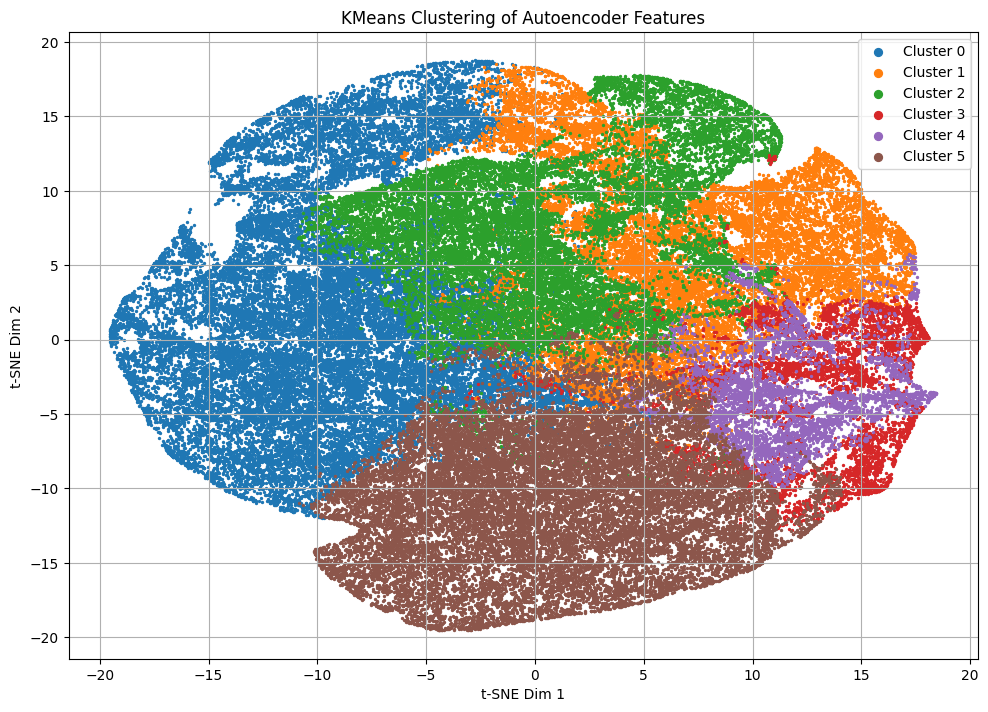

Silhouette Score (Autoencoder features): 0.2417


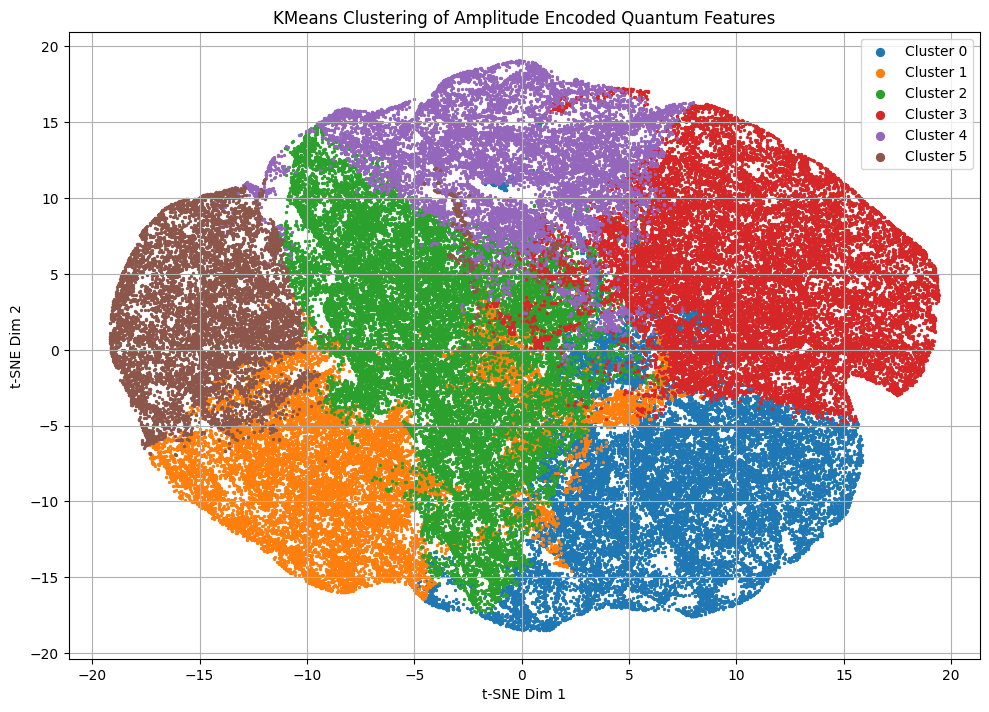

Silhouette Score (Amplitude Encoded Quantum features): 0.2529


In [ ]:
# Scale
scaler = StandardScaler()
X_autoenc_scaled = scaler.fit_transform(X_autoenc)
quantum_scaled = scaler.fit_transform(quantum_full)

# KMeans with 6 clusters
kmeans_auto = KMeans(n_clusters=6, random_state=0)
labels_auto = kmeans_auto.fit_predict(X_autoenc_scaled)

kmeans_quantum = KMeans(n_clusters=6, random_state=0)
labels_quantum = kmeans_quantum.fit_predict(quantum_scaled)

# Silhouette scores
score_auto = silhouette_score(X_autoenc_scaled, labels_auto)
score_quantum = silhouette_score(quantum_scaled, labels_quantum)

# t-SNE
tsne_auto = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=0, n_iter=500)
X_tsne_auto = tsne_auto.fit_transform(X_autoenc_scaled)

tsne_quantum = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=0, n_iter=500)
X_tsne_quantum = tsne_quantum.fit_transform(quantum_scaled)

# Plot for Autoencoder
plt.figure(figsize=(10, 7))
for i in range(6):
    cluster_points = X_tsne_auto[labels_auto == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=2, label=f'Cluster {i}')
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend(markerscale=4)
plt.grid(True)
plt.tight_layout()
plt.title("KMeans Clustering of Autoencoder Features")
plt.show()

print(f"Silhouette Score (Autoencoder features): {score_auto:.4f}")

# -Plot for Quantum Amplitude Encoded
plt.figure(figsize=(10, 7))
for i in range(6):
    cluster_points = X_tsne_quantum[labels_quantum == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=2, label=f'Cluster {i}')
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend(markerscale=4)
plt.grid(True)
plt.tight_layout()
plt.title("KMeans Clustering of Amplitude Encoded Quantum Features")
plt.show()

print(f"Silhouette Score (Amplitude Encoded Quantum features): {score_quantum:.4f}")

# K-Means Clustering with 5 Clusters

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


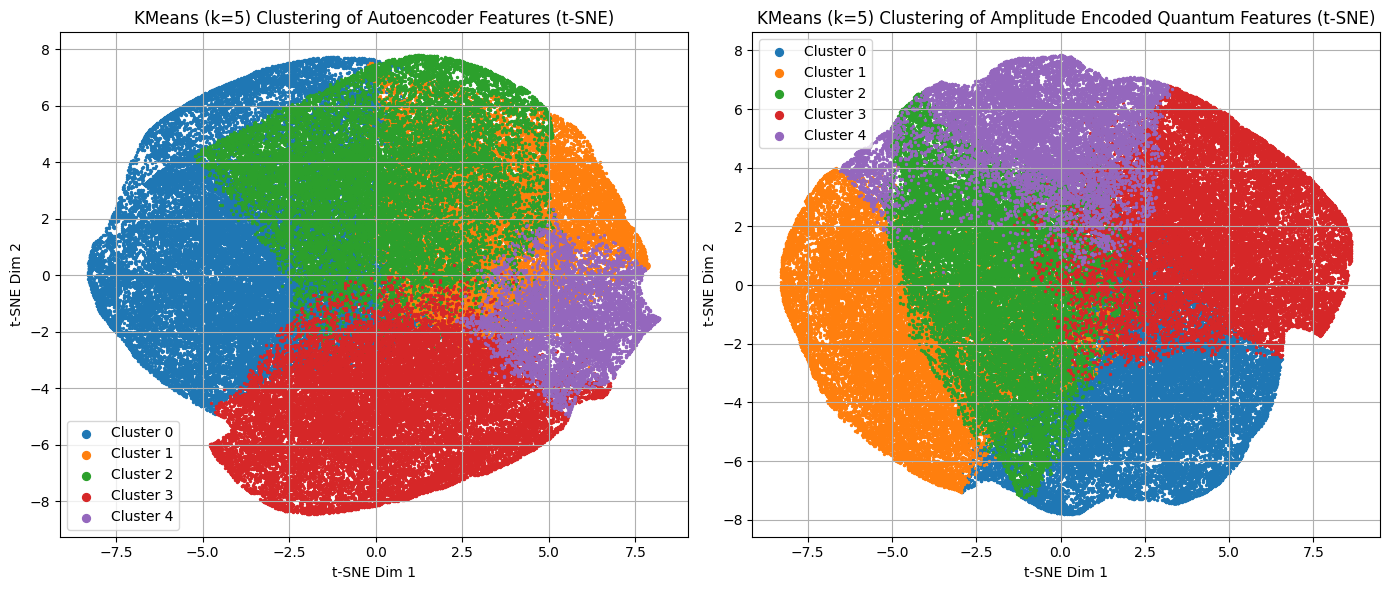

Silhouette Score (Autoencoder features, 5 clusters): 0.2384
Silhouette Score (Amplitude Encoded Quantum features, 5 clusters): 0.2556


In [ ]:
# Scale both datasets
scaler = StandardScaler()
X_autoenc_scaled = scaler.fit_transform(X_autoenc)
quantum_scaled = scaler.fit_transform(quantum_full)

# KMeans with 5 clusters
kmeans_auto_5 = KMeans(n_clusters=5, random_state=0)
labels_auto_5 = kmeans_auto_5.fit_predict(X_autoenc_scaled)

kmeans_quantum_5 = KMeans(n_clusters=5, random_state=0)
labels_quantum_5 = kmeans_quantum_5.fit_predict(quantum_scaled)

# Silhouette scores
score_auto_5 = silhouette_score(X_autoenc_scaled, labels_auto_5)
score_quantum_5 = silhouette_score(quantum_scaled, labels_quantum_5)


tsne_auto_5 = TSNE(n_components=2, perplexity=20, learning_rate=150, n_iter=350, random_state=0)
X_tsne_auto_5 = tsne_auto_5.fit_transform(X_autoenc_scaled)

tsne_quantum_5 = TSNE(n_components=2, perplexity=20, learning_rate=150, n_iter=350, random_state=0)
X_tsne_quantum_5 = tsne_quantum_5.fit_transform(quantum_scaled)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# t-SNE Plot for Autoencoder
for i in range(5):
    cluster_points = X_tsne_auto_5[labels_auto_5 == i]
    axes[0].scatter(cluster_points[:, 0], cluster_points[:, 1], s=2, label=f'Cluster {i}')
axes[0].set_title("KMeans (k=5) Clustering of Autoencoder Features (t-SNE)")
axes[0].set_xlabel("t-SNE Dim 1")
axes[0].set_ylabel("t-SNE Dim 2")
axes[0].grid(True)
axes[0].legend(markerscale=4)

# t-SNE Plot for Amplitude Encoded Quantum
for i in range(5):
    cluster_points = X_tsne_quantum_5[labels_quantum_5 == i]
    axes[1].scatter(cluster_points[:, 0], cluster_points[:, 1], s=2, label=f'Cluster {i}')
axes[1].set_title("KMeans (k=5) Clustering of Amplitude Encoded Quantum Features (t-SNE)")
axes[1].set_xlabel("t-SNE Dim 1")
axes[1].set_ylabel("t-SNE Dim 2")
axes[1].grid(True)
axes[1].legend(markerscale=4)

plt.tight_layout()
plt.show()

# Print silhouette scores
print(f"Silhouette Score (Autoencoder features, 5 clusters): {score_auto_5:.4f}")
print(f"Silhouette Score (Amplitude Encoded Quantum features, 5 clusters): {score_quantum_5:.4f}")

# DBSCAN

In [9]:
from sklearn.cluster import DBSCAN

scaler = StandardScaler()
X_autoenc_scaled = scaler.fit_transform(X_autoenc)
quantum_scaled = scaler.fit_transform(quantum_full)

eps = 1.5
min_samples = 5

dbscan_auto = DBSCAN(eps=eps, min_samples=min_samples)
labels_auto_db = dbscan_auto.fit_predict(X_autoenc_scaled)

dbscan_quantum = DBSCAN(eps=eps, min_samples=min_samples)
labels_quantum_db = dbscan_quantum.fit_predict(quantum_scaled)

# Cluster counts
n_clusters_auto = len(set(labels_auto_db)) - (1 if -1 in labels_auto_db else 0)
n_clusters_quantum = len(set(labels_quantum_db)) - (1 if -1 in labels_quantum_db else 0)

# Valid points for silhouette score
valid_auto = labels_auto_db != -1
valid_quantum = labels_quantum_db != -1

score_auto_db = silhouette_score(X_autoenc_scaled[valid_auto], labels_auto_db[valid_auto]) if n_clusters_auto > 1 else -1
score_quantum_db = silhouette_score(quantum_scaled[valid_quantum], labels_quantum_db[valid_quantum]) if n_clusters_quantum > 1 else -1

# t-SNE Embedding
tsne_auto_db = TSNE(n_components=2, perplexity=20, learning_rate=150, n_iter=350, random_state=0)
X_tsne_auto_db = tsne_auto_db.fit_transform(X_autoenc_scaled)

tsne_quantum_db = TSNE(n_components=2, perplexity=20, learning_rate=150, n_iter=350, random_state=0)
X_tsne_quantum_db = tsne_quantum_db.fit_transform(quantum_scaled)

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


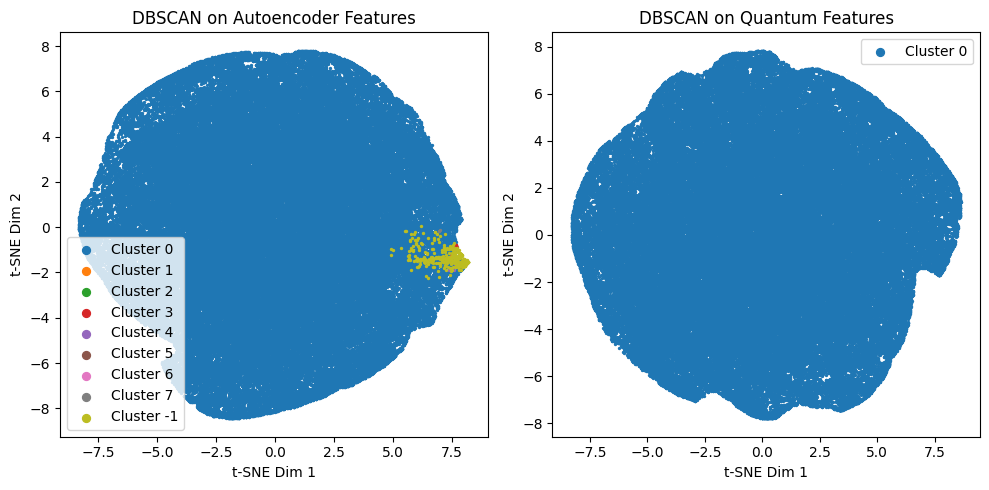

DBSCAN Autoencoder → Clusters: 8, Silhouette: 0.4993
DBSCAN Quantum    → Clusters: 1, Silhouette: -1.0000


In [10]:
# Plot Autoencoder DBSCAN
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
for label in set(labels_auto_db):
    cluster = X_tsne_auto_db[labels_auto_db == label]
    plt.scatter(cluster[:, 0], cluster[:, 1], s=2, label=f'Cluster {label}')
plt.title("DBSCAN on Autoencoder Features")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend(markerscale=4)

# Plot Quantum DBSCAN
plt.subplot(1, 2, 2)
for label in set(labels_quantum_db):
    cluster = X_tsne_quantum_db[labels_quantum_db == label]
    plt.scatter(cluster[:, 0], cluster[:, 1], s=2, label=f'Cluster {label}')
plt.title("DBSCAN on Quantum Features")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend(markerscale=4)

plt.tight_layout()
plt.show()

# Print silhouette scores and number of clusters
print(f"DBSCAN Autoencoder → Clusters: {n_clusters_auto}, Silhouette: {score_auto_db:.4f}")
print(f"DBSCAN Quantum    → Clusters: {n_clusters_quantum}, Silhouette: {score_quantum_db:.4f}")

In [11]:
if score_auto_db != -1:
    print(f"Silhouette Score (Autoencoder features, DBSCAN): {score_auto_db:.4f}")
else:
    print("Autoencoder DBSCAN: Too few clusters for silhouette score")

if score_quantum_db != -1:
    print(f"Silhouette Score (Quantum features, DBSCAN): {score_quantum_db:.4f}")
else:
    print("Quantum DBSCAN: Too few clusters for silhouette score")

print(f"DBSCAN Autoencoder clusters found: {n_clusters_auto}")
print(f"DBSCAN Quantum clusters found: {n_clusters_quantum}")

Silhouette Score (Autoencoder features, DBSCAN): 0.4993
Quantum DBSCAN: Too few clusters for silhouette score
DBSCAN Autoencoder clusters found: 8
DBSCAN Quantum clusters found: 1


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


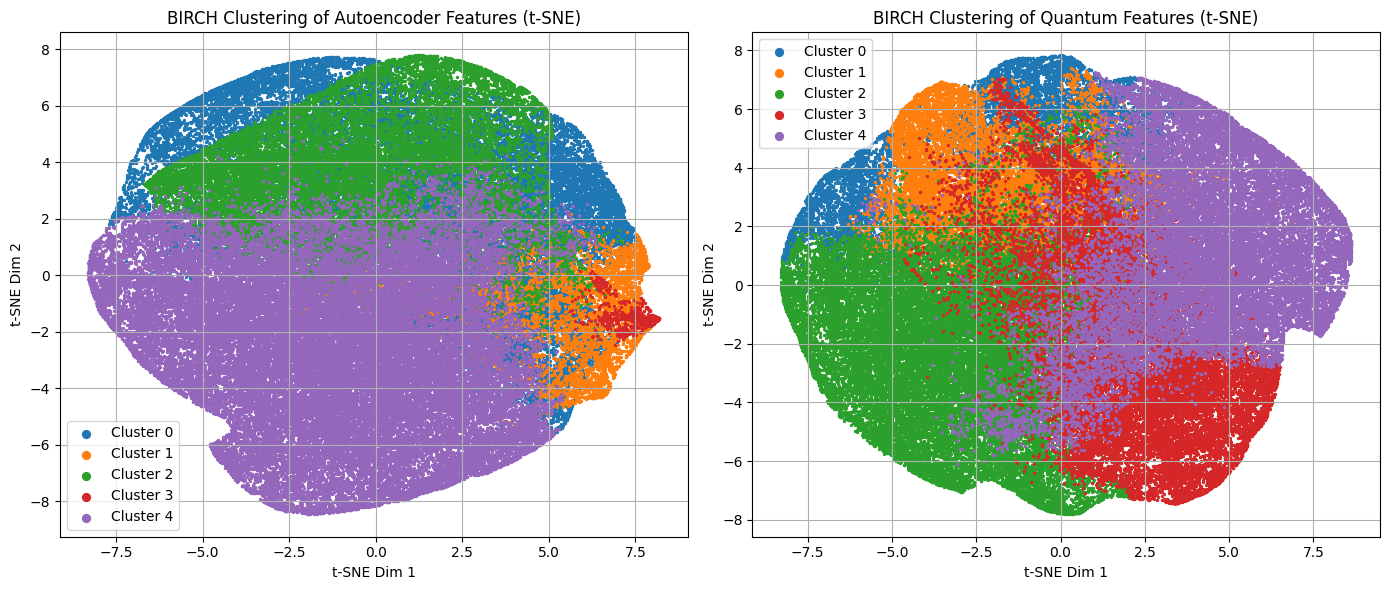

Silhouette Score (Autoencoder features, BIRCH): 0.1774
Silhouette Score (Quantum features, BIRCH): 0.1704


In [12]:
from sklearn.cluster import Birch

scaler = StandardScaler()
X_autoenc_scaled = scaler.fit_transform(X_autoenc)
quantum_scaled = scaler.fit_transform(quantum_full)

# BIRCH Clustering
birch_auto = Birch(n_clusters=5)
labels_auto_birch = birch_auto.fit_predict(X_autoenc_scaled)

birch_quantum = Birch(n_clusters=5)
labels_quantum_birch = birch_quantum.fit_predict(quantum_scaled)

# Silhouette Scores
score_auto_birch = silhouette_score(X_autoenc_scaled, labels_auto_birch)
score_quantum_birch = silhouette_score(quantum_scaled, labels_quantum_birch)

#  t-SNE for Visualization
tsne_auto = TSNE(n_components=2, perplexity=20, learning_rate=150, n_iter=350, random_state=0)
X_tsne_auto = tsne_auto.fit_transform(X_autoenc_scaled)

tsne_quantum = TSNE(n_components=2, perplexity=20, learning_rate=150, n_iter=350, random_state=0)
X_tsne_quantum = tsne_quantum.fit_transform(quantum_scaled)


fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Autoencoder BIRCH
for i in range(5):
    cluster_points = X_tsne_auto[labels_auto_birch == i]
    axes[0].scatter(cluster_points[:, 0], cluster_points[:, 1], s=2, label=f'Cluster {i}')
axes[0].set_title("BIRCH Clustering of Autoencoder Features (t-SNE)")
axes[0].set_xlabel("t-SNE Dim 1")
axes[0].set_ylabel("t-SNE Dim 2")
axes[0].legend(markerscale=4)
axes[0].grid(True)

# Quantum BIRCH
for i in range(5):
    cluster_points = X_tsne_quantum[labels_quantum_birch == i]
    axes[1].scatter(cluster_points[:, 0], cluster_points[:, 1], s=2, label=f'Cluster {i}')
axes[1].set_title("BIRCH Clustering of Quantum Features (t-SNE)")
axes[1].set_xlabel("t-SNE Dim 1")
axes[1].set_ylabel("t-SNE Dim 2")
axes[1].legend(markerscale=4)
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Print Silhouette Scores
print(f"Silhouette Score (Autoencoder features, BIRCH): {score_auto_birch:.4f}")
print(f"Silhouette Score (Quantum features, BIRCH): {score_quantum_birch:.4f}")
